### This a tutorial of color palette completion for graphic documents stored as json files.
- Step1: Extract the color palettes and text from json file
    - In this work:
        - Color palettes are from Image-SVG-Text elements
        - Text contains text contexts in design and image labels by Vision API object detection
- Step2: Extract the text embedding from CLIP model
- Step3: Mask the color positions and get the recommended colors based on text and unmasked colors

In [1]:
import json
import io
import os
import numpy as np
import cv2
import time
from operator import itemgetter, attrgetter
from PIL import Image
import matplotlib.pyplot as plt
from ipywidgets import Image as ipyImage
from ipycanvas import Canvas
from base64 import b64encode, b64decode
import pandas as pd
from datetime import datetime
from collections import defaultdict  # For word frequency
import math
import random
import ast

import sys
sys.path.append('../src')

from color_palette_completion.utils.color_convertor import lab_to_rgb, rgb_to_lab, range0to255, imageRGBA2LAB
from color_palette_completion.utils.image_label_detector import detect_labels
from color_palette_completion.preprocess.color_extractor import get_colors
from color_palette_completion.text_color_model.input_data_generator import DataGenerator
from color_palette_completion.text_color_model.model_config import Config
from color_palette_completion.utils.text_emb_creator import save_text_embedding_clip

representation = Config['representation']
bin_range = Config['bin_range']

# reset the sample url to check different samples
sample_path = '../data/samples'
sample_url = f'{sample_path}/crello_json/276.json'

2023-10-23 02:27:53.592623: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0


##### Step1: extract the color palettes and text from json file
- Convert image data RGB to CIELab
- Use Kmeans clustering in sklearn (kmeans in faiss can be faster, while the result is a little different)
- Check the extracted colors by converting Lab to RGB

In [2]:
# reshape image as [w*h, 3] to concate multiple images
def reshape_image(pil_image):
    image = np.array(pil_image)
    # remove the 4th channel of image
    if len(image.shape) > 2 and image.shape[2] == 4:
        #convert the image from RGBA2RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR) # Alpha channel may should be concerned in future work
    image = image.reshape((image.shape[0] * image.shape[1], 3))
    return image

# draw palette without color rate
def draw_palette(colors):
    palette = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
    for c in range(len(colors)):
        endX = startX + (1 / len(colors) * 300)
        cv2.rectangle(palette, (int(startX), 0), (int(endX), 50), colors[c], -1)
        startX = endX
    # draw border line for easy check in light gray #D3D3D3 
    cv2.rectangle(palette, (0, 0), (300, 50), (211, 211, 211), 2)
    plt.imshow(palette)
    plt.axis('off')
    plt.show()

def draw_palettes(data_input, column_names):
    for item, row in data_input.iterrows():
        for cn in column_names:
            if row[cn] == row[cn]: # string isNaN check
                colors_lab = ast.literal_eval(row[cn])
                colors = [lab_to_rgb(color) for color in colors_lab]
                draw_palette(colors)      

Image palette:
RGB data: [[182, 152, 151], [52, 47, 55], [212, 216, 223], [89, 106, 120], [141, 83, 65]]
Lab data: [[167, 139, 133], [52, 132, 124], [220, 128, 124], [112, 125, 118], [106, 150, 149]]


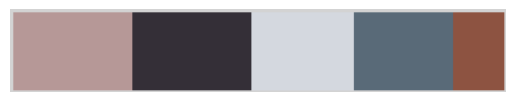

SVG palette:
RGB data: [[220, 38, 41], [19, 45, 81], [255, 255, 255]]
Lab data: [[122, 195, 173], [47, 132, 103], [255, 128, 128]]


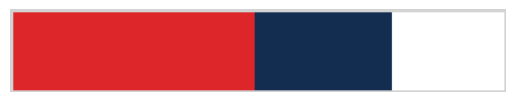

Text palette:
RGB data: [[255, 255, 255]]
Lab data: [[255, 128, 128]]


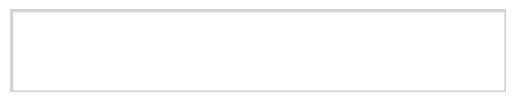

Canvas(height=315, sync_image_data=True, width=851)

In [3]:
# load json file and show multiple palettes of Image-SVG-Text elements and the whole design image
# save the color and text info into a temp file

def line_break(text, height, font_size):
    text = text.replace('\n', ' ')
    lines = round(height / font_size)
    words = text.split(' ')
    lineWordNum = math.ceil(len(words) / lines)
    newText = ''
    idx = 0
    for w in words:
        newText += w
        idx += 1
        if idx % lineWordNum == 0:
            newText += '\n'
        else:
            newText += ' '            
    return newText

with open(sample_url) as json_file:
    example = json.load(json_file)

    columns = ['id', 'group', 'format', 'category', 
                'text_contents', 'image_labels',
                'image_colors', 'svg_colors', 'text_colors',
                'image_colors_lab', 'svg_colors_lab', 'text_colors_lab',
                'image_colors_lab_reorder', 'svg_colors_lab_reorder', 'text_colors_lab_reorder']
    df_text_palette = pd.DataFrame(columns = columns)
    df_text_palette.at[0, 'id'] = example['id']
    df_text_palette.at[0, 'group'] = example['group']
    df_text_palette.at[0, 'format'] = example['format']
    df_text_palette.at[0, 'category'] = example['category']

    canvas_width = example['canvas_width']
    canvas_height = example['canvas_height']
    # draw all elements in canvas
    canvas = Canvas(width=canvas_width, height=canvas_height, sync_image_data=True)

    # initial image_list, svg_list, text_list
    image_list = []
    svg_list = []
    text_list = []
    text_size = []

    # initial for text contents
    text_contents = []
    # initial for image contents detection (class)
    image_labels = []
    max_labels = 30

    for i in range(len(example['types'])):
        layer = example[f'element_{i}']
        x = layer['left']*canvas_width
        y = layer['top']*canvas_height
        width = layer['width']*canvas_width
        height = layer['height']*canvas_height
        color_rgb = layer['color']
        color_hex = '#%02x%02x%02x' % (color_rgb[0], color_rgb[1], color_rgb[2])

        # reconstruct canvas to check
        image = ipyImage.from_file(io.BytesIO(b64decode(layer['image_bytes'])))

        if example['types'][i] == 'imageElement' or example['types'][i] == 'maskElement':
            image_pil = Image.open(io.BytesIO(b64decode(layer['image_bytes'])))
            image_list.append(reshape_image(imageRGBA2LAB(image_pil)))
            # object detection for image
            image_labels.append(detect_labels(b64decode(layer['image_bytes'])))
            canvas.draw_image(image, x, y, width, height)    

        if example['types'][i] == 'svgElement' or example['types'][i] == 'coloredBackground':
            svg_pil = Image.open(io.BytesIO(b64decode(layer['image_bytes'])))
            svg_list.append(reshape_image(imageRGBA2LAB(svg_pil)))
            canvas.draw_image(image, x, y, width, height)    

        if example['types'][i] == 'textElement':
            if [color_rgb[0], color_rgb[1], color_rgb[2]] not in text_list:
                text_list.append([color_rgb[0], color_rgb[1], color_rgb[2]])
                text_size.append(width * height)

            text = layer['text']
            text_contents.append(layer['text'])
            font = layer['font']
            font_size = layer['font_size']
            text_align = layer['text_align']
            x = x + width if text_align == 'right' else x
            x = x + width/2 if text_align == 'center' else x
            angle = layer['angle']
            
            canvas.font = f'{font_size}px {font}'
            color_rgb = layer['color']
            color_hex = '#%02x%02x%02x' % (color_rgb[0], color_rgb[1], color_rgb[2])
            canvas.stroke_style = color_hex
            canvas.fill_style = color_hex
            canvas.rotate = angle / math.pi * 180
            canvas.text_align = text_align
            text = line_break(text, height, font_size)
            texts = text.split('\n')
            for t in range(len(texts)):
                canvas.fill_text(texts[t], x, y+font_size*(t+1), max_width = width)
                time.sleep(2) # sleep more time when text can not be fully stored
                
    for i in range(len(image_list)):
        if i == 0:
            image_np = image_list[i]
        else:
            image_np = np.concatenate((image_np, image_list[i]), axis=0)

    for i in range(len(svg_list)):
        if i == 0:
            svg_np = svg_list[i]
        else:
            svg_np = np.concatenate((svg_np, svg_list[i]), axis=0)

    # sort text color list by text area size
    text_list = [x for _, x in sorted(zip(text_size, text_list), reverse=True)]
    if len(text_list) > 5:
        text_np = np.array(text_list)
        (text_colors, text_colors_lab, text_color_rates, text_palette) = get_colors(text_np, 5)
    else:
        text_colors = text_list
        text_colors_lab = [rgb_to_lab(rgb) for rgb in text_list]

    if len(image_list) > 0:
        (image_colors, image_colors_lab, image_color_rates, image_palette) = get_colors(image_np, 5)
        df_text_palette.at[0, 'image_colors'] = image_colors
        df_text_palette.at[0, 'image_colors_lab'] = image_colors_lab
        image_colors_lab_reorder = image_colors_lab.copy()
        image_colors_lab_reorder.sort(key=lambda x: x[0], reverse=False) # sort by lightness increasing
        df_text_palette.at[0, 'image_colors_lab_reorder'] = image_colors_lab_reorder

    if len(svg_list) > 0:
        (svg_colors, svg_colors_lab, svg_color_rates, svg_palette) = get_colors(svg_np, 5)
        df_text_palette.at[0, 'svg_colors'] = svg_colors
        df_text_palette.at[0, 'svg_colors_lab'] = svg_colors_lab
        svg_colors_lab_reorder = svg_colors_lab.copy()
        svg_colors_lab_reorder.sort(key=lambda x: x[0], reverse=False) # sort by lightness increasing
        df_text_palette.at[0, 'svg_colors_lab_reorder'] = svg_colors_lab_reorder
    
    if len(text_list) > 0:
        df_text_palette.at[0, 'text_colors'] = text_colors
        df_text_palette.at[0, 'text_colors_lab'] = text_colors_lab
        text_colors_lab_reorder = text_colors_lab.copy()
        text_colors_lab_reorder.sort(key=lambda x: x[0], reverse=False) # sort by lightness increasing
        df_text_palette.at[0, 'text_colors_lab_reorder'] = text_colors_lab_reorder

    if texts:
        df_text_palette.at[0, f'text_contents'] = text_contents
    
    label_list = []
    for i in range(len(image_labels)):
        top_labels_i = image_labels[i]
        for l in range(min(len(top_labels_i), Config['Max_Image_Labels_Length'])):
            label_list.append(top_labels_i[l].description)
    df_text_palette.at[0, f'image_labels'] = label_list

    df_text_palette.to_csv(f'{sample_path}/colors/text_palette.csv', index = False, header=True)

    print('Image palette:')
    print(f'RGB data: {image_colors}')
    print(f'Lab data: {image_colors_lab}')
    plt.imshow(image_palette)
    plt.axis('off')
    plt.show()

    print('SVG palette:')
    print(f'RGB data: {svg_colors}')
    print(f'Lab data: {svg_colors_lab}')
    plt.imshow(svg_palette)
    plt.axis('off')
    plt.show()

    print('Text palette:')
    print(f'RGB data: {text_colors}')
    print(f'Lab data: {text_colors_lab}')
    draw_palette(text_colors)

canvas

In [4]:
# change the color-text info to new input -> Here is a sample of changing 1 image
# 2 input cases are offered in this tutorial
# save the color and text info in a temp file

# new input case1
# image_input = f'{sample_path}/images/145.png'
# text_contents_input = ['International Day of Forests', 'Joint celebration & forest cleanup special event']

# new input case2
image_input = f'{sample_path}/images/2045.png'
text_contents_input = ['Wedding party', 'How to prepare']

rawdata = pd.read_csv(f'{sample_path}/colors/text_palette.csv')
with Image.open(image_input) as img:
    image_np = reshape_image(imageRGBA2LAB(img))
    (image_colors, image_colors_lab, image_color_rates, image_palette) = get_colors(image_np, 5)
    rawdata['image_colors'] = str(image_colors)
    rawdata['image_colors_lab'] = str(image_colors_lab)
    image_colors_lab_reorder = image_colors_lab.copy()
    image_colors_lab_reorder.sort(key=lambda x: x[0], reverse=False) # sort by lightness increasing
    rawdata['image_colors_lab_reorder'] = str(image_colors_lab_reorder)

    buffer = io.BytesIO()
    img.save(buffer, format="png")
    image_labels = detect_labels(buffer.getvalue())
    label_list = []
    for l in range(min(len(image_labels), Config['Max_Image_Labels_Length'])):
        label_list.append(image_labels[l].description)
    rawdata['image_labels'] = str(label_list)
    rawdata['text_contents'] = str(text_contents_input)

    rawdata.to_csv(f'{sample_path}/colors/text_palette_new.csv', index=None, sep=',')

#### Step2: Extract the text embedding from CLIP model
- Save the embeddings in temp files for prediction

In [5]:
color_data_path = 't2p/color'
text_data_path = 't2p/text'

langType = '_en'

text_model = '_clip'
emb_file = 'emb_clip_seq'

def get_color_list_bins(data, column_names):
    color_hist = ''
    for column in column_names:
        if pd.notna(data[column]):
            colors = ast.literal_eval(data[column])
            for color in colors:
                if color_hist != '':
                    color_hist += ' '
                color_hist += f'{math.floor(color[0]/bin_range)}_{math.floor(color[1]/bin_range)}_{math.floor(color[2]/bin_range)}'
    return color_hist

column_names = ['image_colors_lab_reorder', 'svg_colors_lab_reorder', 'text_colors_lab_reorder']

def get_color_metadata(data, representation):

    for column in column_names:
        data[f'{column}'] = data.apply(lambda x: get_color_list_bins(x, [column]), axis=1)
        
    return data

def get_color_hist(data, column_names):
    color_hist = ''
    color_hist += f'{data[column_names[0]]} ; {data[column_names[1]]} ; {data[column_names[2]]}'

    return color_hist

def create_colordata(file_path, representation):
    data = pd.read_csv(file_path)
    data = data.reset_index(drop=True)
    
    metadata = get_color_metadata(data, representation)
    metadata['color_hist'] = metadata.apply(lambda x: get_color_hist(x, column_names), axis=1)
    return metadata

In [6]:
metadata = create_colordata(f'{sample_path}/colors/text_palette_new.csv', representation)
metadata['color_hist'].to_csv(f'{sample_path}/t2p/color/color_corpus_pred.txt', header=None, index=None, sep=' ')
metadata['text_contents'].to_csv(f'{sample_path}/t2p/text/text_contents.txt', header=None, index=None, sep=' ')
metadata['image_labels'].to_csv(f'{sample_path}/t2p/text/image_labels.txt', header=None, index=None, sep=' ')

In [7]:
text_columns = ['text_contents', 'image_labels']
max_text_seq_length = {
    'text_contents': Config['Max_Text_Contents_Length'],
    'image_labels': Config['Max_Image_Labels_Length'],
}

for text_column in text_columns:
    lines_as_lists = []

    # open the file in read mode
    with open(f'{sample_path}/t2p/text/{text_column}.txt', 'r') as file:
        for line in file:
            line = line.strip().strip('"')
            try:
                parsed_list = ast.literal_eval(line)
                lines_as_lists.append(parsed_list)
            except ValueError as e:
                print(f"Could not parse line: {line}. Error: {e}")

    # only deal with the first line text
    print(lines_as_lists[0])
    
    # create and save text embeddings
    dataType = 'sample'
    sample_data_path = f'{sample_path}/t2p/text/emb_clip'
    print(f'start build {dataType} text contents embedding: {datetime.now().strftime("%Y-%m-%d-%H:%M:%S")}')
    text_contents_emb = save_text_embedding_clip(lines_as_lists[0], sample_data_path, text_column, dataType, max_text_seq_length[text_column])
    print(f'finish build {dataType} text contents embedding: {datetime.now().strftime("%Y-%m-%d-%H:%M:%S")}')

['Wedding party', 'How to prepare']
start build sample text contents embedding: 2023-10-23-02:28:22
../data/samples/t2p/text/emb_clip/text_contents_emb_clip_sample.txt has been removed successfully
finish build sample text contents embedding: 2023-10-23-02:28:29
['Food', 'Cake decorating', 'Cake decorating supply', 'Ingredient', 'Cake', 'Recipe', 'Cuisine', 'Baked goods', 'Cream', 'Baking cup']
start build sample text contents embedding: 2023-10-23-02:28:29
../data/samples/t2p/text/emb_clip/image_labels_emb_clip_sample.txt has been removed successfully
finish build sample text contents embedding: 2023-10-23-02:28:34


#### Step3: Mask the color positions and get the recommended colors based on text and unmasked colors

In [8]:
import tensorflow as tf

filename = f'../data/trained_model/t2p_ca1_mca1_i10t_stop30_lr0.0002__clip_512d_lab_bins_16_0.4_0.5_0'
re_model = tf.keras.models.load_model(f"{filename}")

2023-10-23 02:28:34.730103: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-10-23 02:28:34.730353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-23 02:28:34.732126: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2023-10-23 02:28:34.732187: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.11.0
2023-10-23 02:28:34.732261: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11
2023-10-23 02:28:34.733448: I tensorflow/stream_executor/platform/default/d

Original Image-SVG-Text palettes:


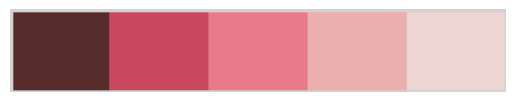

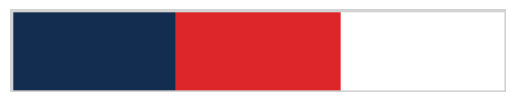

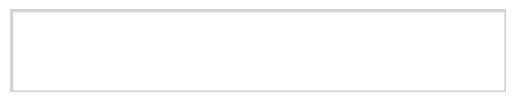

recommendation color for position: 6
original color:


2023-10-23 02:28:42.708103: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.11


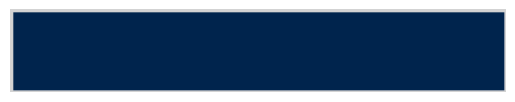

recommended color:


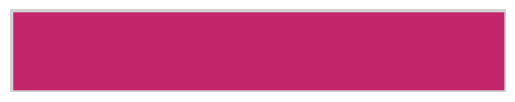

recommendation color for position: 7
original color:


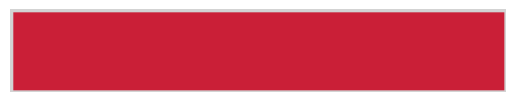

recommended color:


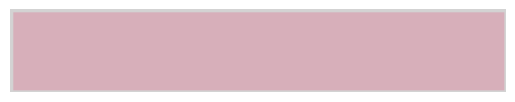

In [9]:
data_pred = pd.read_csv(f'{sample_path}/colors/text_palette_new.csv')

# set mask positions
# 1 denotes mask
maskColors = {
    'image': '[0,0,0,0,0]',
    'svg': '[1,1,0]',
    'text': '[0]',
}
volumns = ['image', 'svg', 'text']
max_palette_length = Config['Max_Palette_Length']
mask_positions = []
position = 0
for v in range(len(volumns)):
    pi = 0
    for m in ast.literal_eval(maskColors[volumns[v]]):
        if m == 1:
            mask_positions.append(position+pi)
        pi +=1
    position += max_palette_length[v] + 1  # add 1 position of SEP
Config_pred = Config.copy()
Config_pred['Batch_Size'] = 1
Config_pred['Mask_position'] = mask_positions   # mask specified colors
Config_pred['Corpus_File_Path'] = os.path.join(f'{sample_path}/t2p/color/color_corpus_pred.txt')
Config_pred['Text_Contents_File_Path'] = os.path.join(f'{sample_path}/t2p/text/text_contents.txt')
Config_pred['Image_Labels_File_Path'] = os.path.join(f'{sample_path}/t2p/text/image_labels.txt')
Config_pred['Text_Contents_Emb_File_Path'] = os.path.join(f'{sample_path}/t2p/text/emb_clip/text_contents_emb_clip_sample.txt')
Config_pred['Image_Labels_Emb_File_Path'] = os.path.join(f'{sample_path}/t2p/text/emb_clip/image_labels_emb_clip_sample.txt')

column_names = ['image_colors_lab_reorder', 'svg_colors_lab_reorder', 'text_colors_lab_reorder']

sample_id = 0
print('Original Image-SVG-Text palettes:')
draw_palettes(data_pred[sample_id:sample_id+1], column_names)

dataset = DataGenerator(Config_pred)
batch_x,  batch_mlm_mask, batch_mcc_mask, origin_x, batch_segment, batch_padding_mask, batch_text_contents_embed, batch_image_labels_embed = dataset[sample_id]

mlm_predict, output_emb = re_model((batch_x, batch_mlm_mask, batch_segment, batch_text_contents_embed, batch_image_labels_embed), training=False)

for pos in Config_pred['Mask_position']:
    classes = np.argsort(mlm_predict[0][pos])
    new_color = dataset.corpus.token_id_to_word_list(list(classes[::-1][:1]))
    print(f'recommendation color for position: {pos}')
    print(f'original color:')
    c = dataset.corpus.token_id_to_word_list(list(origin_x[0]))[pos]
    lab = c.split('_')
    rgb = range0to255(lab_to_rgb([int(lab[0])*bin_range, int(lab[1])*bin_range, int(lab[2])*bin_range]))
    draw_palette([rgb])
    print(f'recommended color:')
    for c in new_color:
        lab = c.split('_')
        rgb = range0to255(lab_to_rgb([int(lab[0])*bin_range, int(lab[1])*bin_range, int(lab[2])*bin_range]))
        draw_palette([rgb])